In [1]:
#Imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns # For all our visualization needs.
import statsmodels.api as sm # What does this do? Find out and type here.
from statsmodels.graphics.api import abline_plot # What does this do? Find out and type here.
from sklearn.metrics import mean_squared_error, r2_score # What does this do? Find out and type here.
from sklearn.model_selection import train_test_split #  What does this do? Find out and type here.
from sklearn import linear_model, preprocessing # What does this do? Find out and type here.
import warnings # For handling error messages.
# Don't worry about the following two instructions: they just suppress warnings that could occur later. 
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
pwd

'C:\\Users\\Armstrongs\\Desktop\\GitHub\\Capstone2'

In [3]:
data = 'wrangled_snapshot.csv'
df = pd.read_csv(data)
df.head()

,Unnamed: 0,DISTNAME,DISTRICT #,DZCNTYNM,REGION,DZRATING,DZCAMPUS,total students,4. Students % African American:,5. Students % Hispanic:,...,100. Expenditures % Prekindergarten:,101. Expenditures % Un-Allocated:,DISTSIZE,COMMTYPE,afrdiff,hispdiff,whidiff,asndiff,pacdiff,Racial Dif Stu/Tea
0,0,CAYUGA ISD,1902,001 ANDERSON,7,A,3,564,3.5,6.7,...,0.3,20.8,500 to 999,Rural,0,0,0,0,0,3.63125
1,1,ELKHART ISD,1903,001 ANDERSON,7,A,5,1254,5.4,11.3,...,0.0,25.7,"1,000 to 1,599",Non-metropolitan Stable,0,0,0,0,0,7.40625
2,2,FRANKSTON ISD,1904,001 ANDERSON,7,B,3,803,8.2,8.2,...,1.1,28.2,500 to 999,Rural,0,0,0,0,0,2.98750
3,3,NECHES ISD,1906,001 ANDERSON,7,A,2,366,8.5,13.9,...,0.5,35.1,Under 500,Rural,0,0,0,0,0,10.83750
4,4,PALESTINE ISD,1907,001 ANDERSON,7,B,6,3389,26.6,41.2,...,2.1,28.3,"3,000 to 4,999",Independent Town,0,0,0,0,0,23.65000


In [4]:
#Bringing over some code from datacamp as short cuts
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
 
    # x-data for the ECDF: x
    x = np.sort(data)
 
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
 
    return x, y

def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""
 
    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)
 
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
 
    return bs_replicates

def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""
 
    # Set up array of indices to sample from: inds
    inds = np.arange(0, len(x))
 
    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
 
    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)
 
    return bs_slope_reps, bs_intercept_reps

def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
 
    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))
 
    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)
 
    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]
 
    return perm_sample_1, perm_sample_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""
 
    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)
 
    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
 
        # Compute the test statistic
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)
 
    return perm_replicates
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for a single statistic."""
 
    # Set up array of indices to sample from: inds
    inds = np.arange(len(x), len(x))
 
    # Initialize replicates: bs_replicates
    bs_replicates = np.empty(size)
 
    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)
 
    return bs_replicates

In [5]:
df.shape

(1065, 116)

In [6]:
#Looks like all my values are non-null, everything is float type. Missing values have already been removed or imputed during
#data cleaning. Several identifying columns can be dropped from the beginning including: Unnamed: 0, DISTRICT #, DZCNTYNM,
#REGION, and DZCAMPUS. DZRATING may not be useful as it's just based on the aggregate scores of the other features.
df.iloc[:,:100].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 100 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   Unnamed: 0                                                     1065 non-null   int64  
 1   DISTNAME                                                       1065 non-null   object 
 2   DISTRICT #                                                     1065 non-null   int64  
 3   DZCNTYNM                                                       1065 non-null   object 
 4   REGION                                                         1065 non-null   int64  
 5   DZRATING                                                       1065 non-null   object 
 6   DZCAMPUS                                                       1065 non-null   int64  
 7   total students                                             

In [7]:
#afrdiff - pacdiff can all be dropped as they were just temporary columns created to get Racial Dif Stu/Tea. Details can be 
#Found in last notebook. DISTSIZE and COMMTYPE are going to require a closer look. 
df.iloc[:,100:].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 16 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   94. Expenditures % State Compensatory Education:    1065 non-null   float64
 1   95. Expenditures % Bilingual/ESL Education:         1065 non-null   float64
 2   96. Expenditures % Career and Technical Education:  1065 non-null   float64
 3   97. Expenditures % Gifted and Talented Education:   1065 non-null   float64
 4   98. Expenditures % Athletics/Related Activities:    1065 non-null   float64
 5   99. Expenditures % High School Allotment:           1065 non-null   float64
 6   100. Expenditures % Prekindergarten:                1065 non-null   float64
 7   101. Expenditures % Un-Allocated:                   1065 non-null   float64
 8   DISTSIZE                                            1065 non-null   object 
 9

In [8]:
df['DISTSIZE'].head()

0        500 to 999
1    1,000 to 1,599
2        500 to 999
3         Under 500
4    3,000 to 4,999
Name: DISTSIZE, dtype: object

In [9]:
df['DISTSIZE'].value_counts()

Under 500           294
500 to 999          210
1,000 to 1,599      145
1,600 to 2,999      133
3,000 to 4,999       90
5,000 to 9,999       76
10,000 to 24,999     64
25,000 to 49,999     33
50,000 and over      20
Name: DISTSIZE, dtype: int64

In [10]:
df['COMMTYPE'].head()

0                      Rural
1    Non-metropolitan Stable
2                      Rural
3                      Rural
4           Independent Town
Name: COMMTYPE, dtype: object

In [11]:
df['COMMTYPE'].value_counts()

Rural                            419
Non-metropolitan Stable          166
Other Central City Suburban      164
Charters                          93
Major Suburban                    79
Independent Town                  67
Other Central City                38
Non-metropolitan Fast Growing     28
Major Urban                       11
Name: COMMTYPE, dtype: int64

In [12]:
from sklearn.preprocessing import OneHotEncoder

In [13]:
#These two categorical variables are going to have to be one-hot encoded. Let's start with COMMTYPE
enc_commtype = OneHotEncoder(handle_unknown='ignore')
commtypecats = [['Rural', 1], ['Non-metropolitan Stable', 2], ['Other Central City Suburban', 3], ['Charters', 4], ['Major Suburban', 5], ['Independent Town', 6], ['Other Central City', 7], ['Non-metropolitan Fast Growing', 8], ['Major Urban', 9]]
enc_commtype.fit(commtypecats)

OneHotEncoder(handle_unknown='ignore')

In [14]:
enc_commtype.categories_

[array(['Charters', 'Independent Town', 'Major Suburban', 'Major Urban',
        'Non-metropolitan Fast Growing', 'Non-metropolitan Stable',
        'Other Central City', 'Other Central City Suburban', 'Rural'],
       dtype=object),
 array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=object)]

(array([1.035e+03, 2.000e+01, 2.000e+00, 3.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0. ,  3.7,  7.4, 11.1, 14.8, 18.5, 22.2, 25.9, 29.6, 33.3, 37. ]),
 <BarContainer object of 10 artists>)

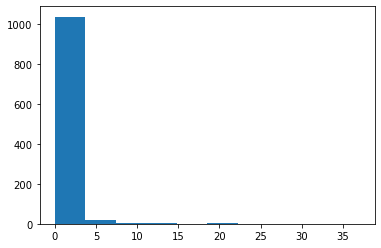

In [15]:
#I'm pretty sure I'm doing hot encoding incorrectly. I'm just going to drop the categorical data for now. I have plenty of 
#Other features. My plan for the deprendent variable is to use dropout rate. Let's take a look at it. 
plt.hist(df['18. Annual Dropout Rate Gr. 9-12 (2017-18):'])

In [16]:
#This is definitely not normally distributed. Let's checkout some statistics for dropout rates and compare them to my target
#district
df['18. Annual Dropout Rate Gr. 9-12 (2017-18):'].describe()

count    1065.000000
mean        0.889355
std         2.103651
min         0.000000
25%         0.000000
50%         0.400000
75%         1.100000
max        37.000000
Name: 18. Annual Dropout Rate Gr. 9-12 (2017-18):, dtype: float64

In [17]:
df.loc[df['DISTNAME'] == 'CLEBURNE ISD', ['18. Annual Dropout Rate Gr. 9-12 (2017-18):']]

,18. Annual Dropout Rate Gr. 9-12 (2017-18):
580,2.0


In [18]:
#Let's just seperate it for easier reference
cleburne = df[df['DISTNAME'] == 'CLEBURNE ISD']

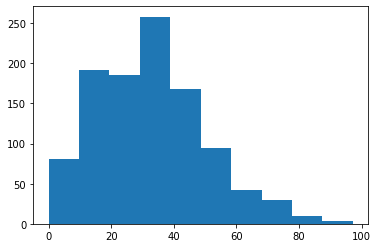

In [19]:
#It looks like the dropout rate for Cleburne ISD is well above the mean and in the top 75% of the data. There are some serious
#outliers though. There are a few other features that might make attractive dependent variables though. Let's check those
#out as well. 
plt.hist(df['39. SAT/ACT Results - % At or Above Criterion (2017-2018): '])
plt.show()

In [20]:
cleburne['39. SAT/ACT Results - % At or Above Criterion (2017-2018): ']

580    30.0
Name: 39. SAT/ACT Results - % At or Above Criterion (2017-2018): , dtype: float64

In [21]:
df['39. SAT/ACT Results - % At or Above Criterion (2017-2018): '].describe()

count    1065.000000
mean       32.457522
std        17.355193
min         0.000000
25%        19.000000
50%        32.100000
75%        42.700000
max        97.200000
Name: 39. SAT/ACT Results - % At or Above Criterion (2017-2018): , dtype: float64

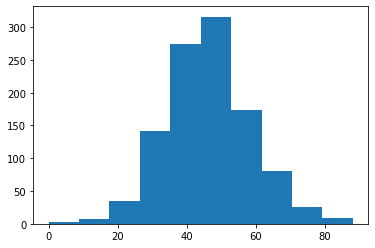

In [22]:
#Cleburne is right around average in terms of SAT performance. 
plt.hist(df['staar all subjects meet'])
plt.show()

In [23]:
cleburne['staar all subjects meet']

580    36.0
Name: staar all subjects meet, dtype: float64

In [24]:
df['staar all subjects meet'].describe()

count    1065.000000
mean       46.130516
std        12.098082
min         0.000000
25%        38.000000
50%        46.000000
75%        53.000000
max        88.000000
Name: staar all subjects meet, dtype: float64

In [25]:
#Looking at these graphs it seems to me like dropout rates are pretty uniform across most school districts and there may
#be some underlying issues that cause dropout rates to go WAY HIGHER for certain areas. Since staar performance has a 
#much greater range, is more normally distributed (though it does seem right tailed), and my target district is much lower
#than the mean for this feature I've decided to predict staat performance instead. 

#The next step is to cut the dataset down into just features that might relate to staar performance using my own domain
#knowledge

In [26]:
df = df.drop(columns=['Unnamed: 0', 'DISTRICT #', 'DZCNTYNM',
'REGION', 'DZCAMPUS', 'DZRATING', 'DISTSIZE', 'COMMTYPE', 'afrdiff', 'hispdiff', 'whidiff', 'asndiff', 'pacdiff'])

In [27]:
#Now let's split the dataframe up and put the dependent variable in each set. 
target = df['staar all subjects meet']

In [28]:
df1 = df.iloc[:,:33]
df2 = df.iloc[:, 33:66]
df3 = df.iloc[:, 66:]

In [29]:
df1['target'] = target
df2['target'] = target
df3['target'] = target
df1.drop(columns=['staar all subjects meet'], inplace = True)


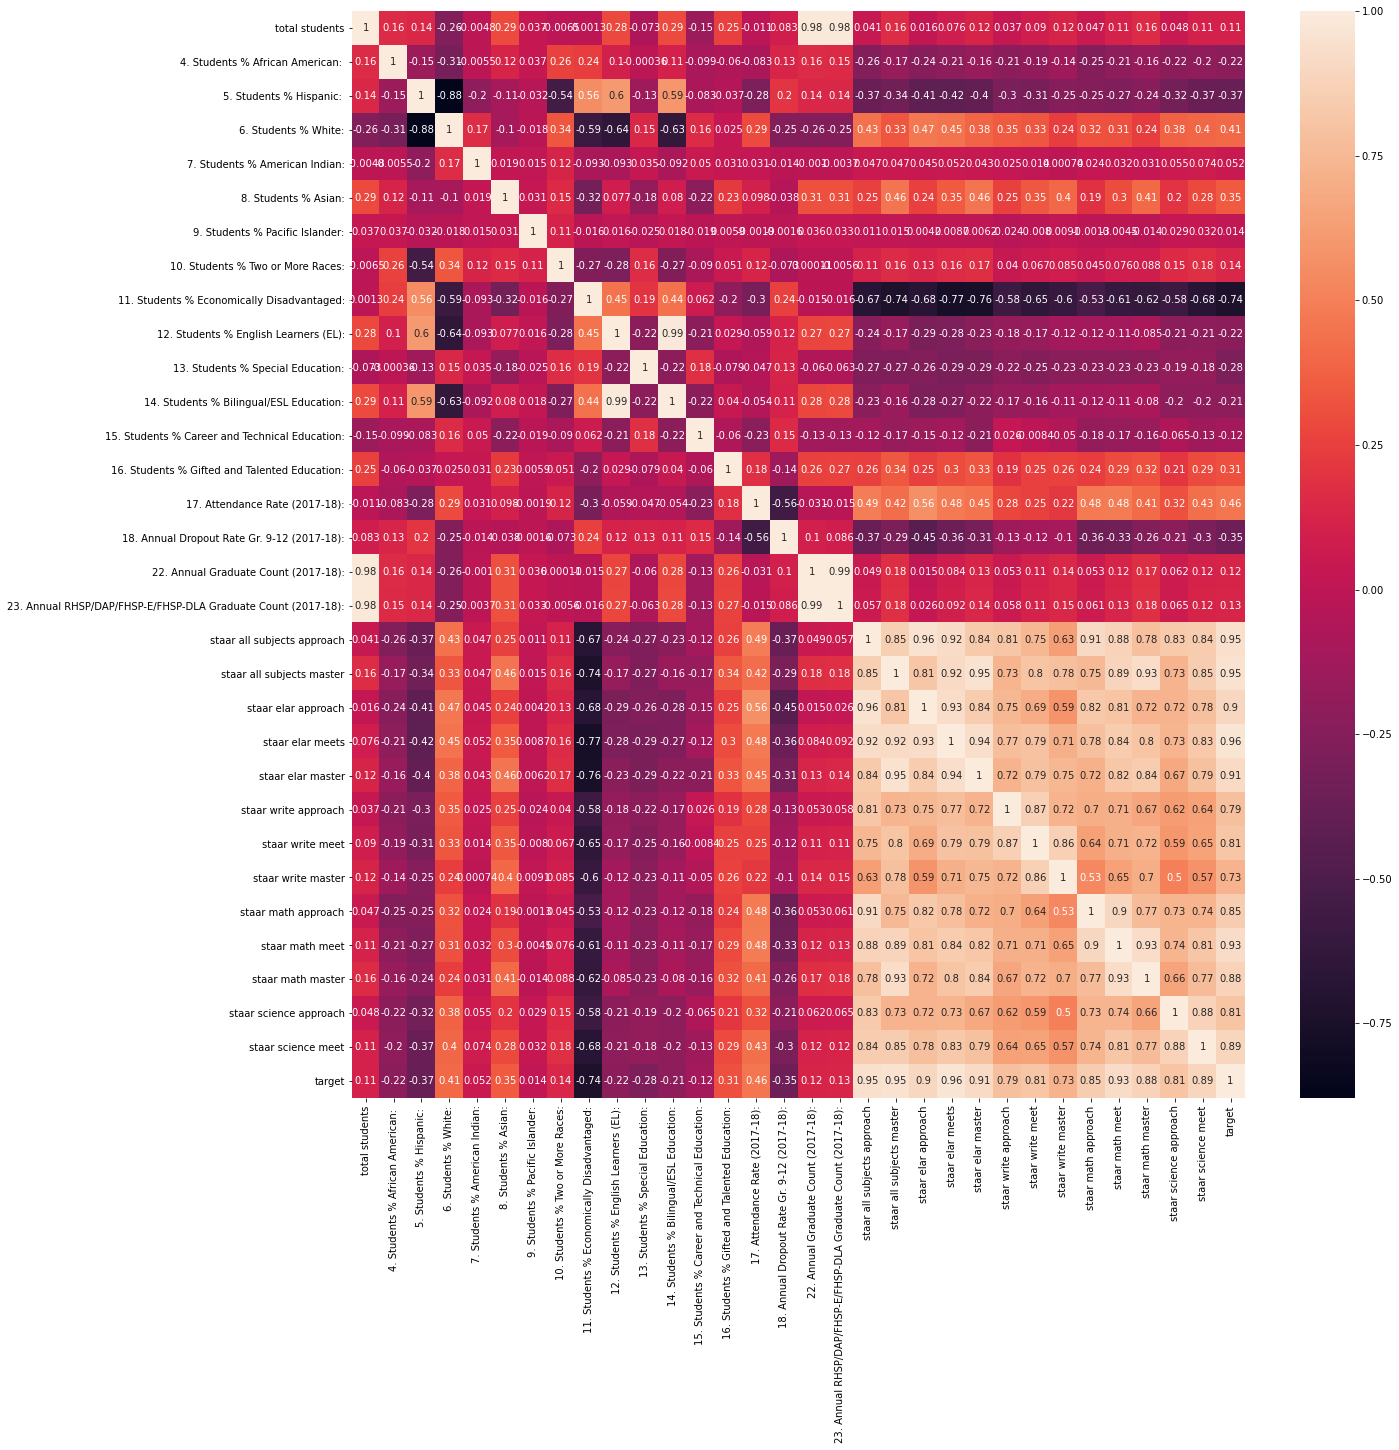

In [30]:
plt.figure(figsize = (20, 20))
sns.heatmap(df1.corr(), annot=True)
plt.show()

In [31]:
#Ok looking at this I should have already guessed that staar meets is going to correlate with star master. Let's just get rid of
#all the staar data that isn't part of the target
df1.drop(columns = ['staar all subjects approach', 'staar all subjects master',
       'staar elar approach', 'staar elar meets', 'staar elar master',
       'staar write approach', 'staar write meet', 'staar write master',
       'staar math approach', 'staar math meet', 'staar math master',
       'staar science approach', 'staar science meet'], inplace=True)

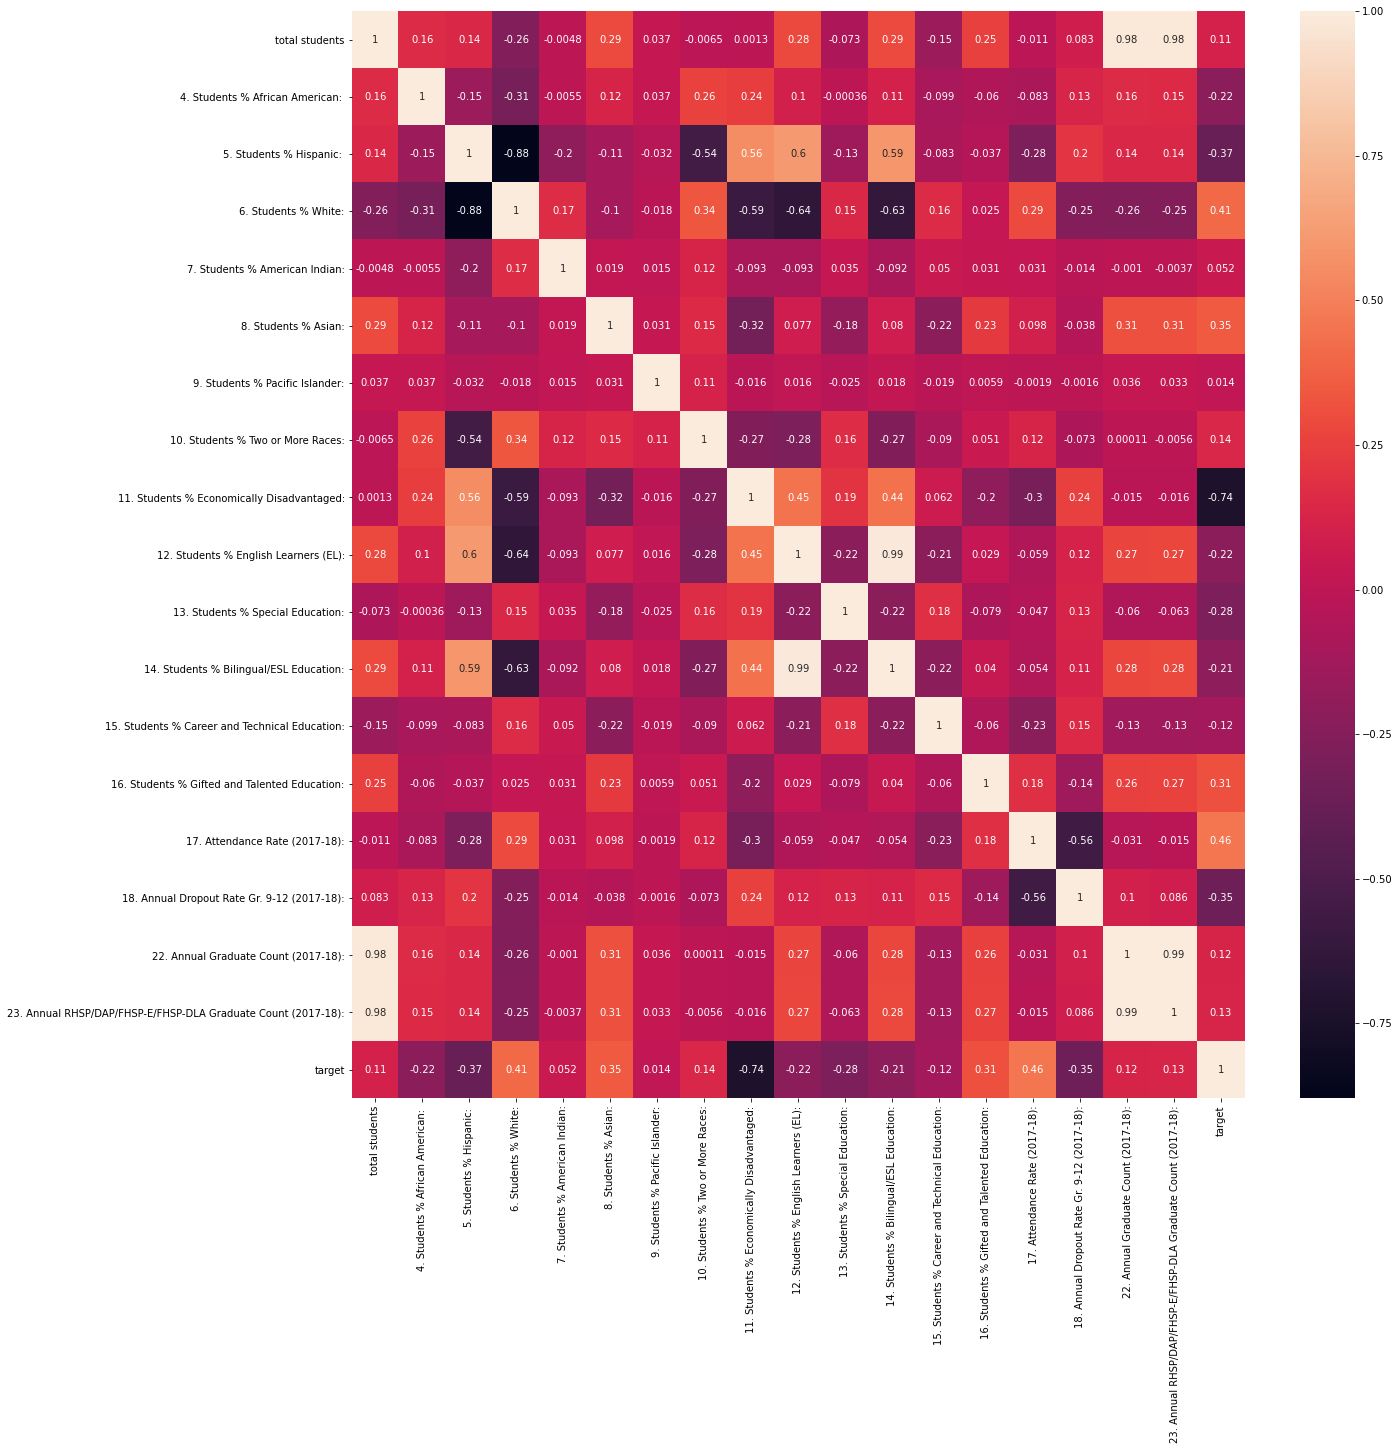

In [32]:
plt.figure(figsize = (20, 20))
sns.heatmap(df1.corr(), annot=True)
plt.show()

In [33]:
#So here our target most strongly correlates to attendence rate. I'm sure this is already common knowledge to most school
#districts. Let's see if I can find something more insightful. 

In [34]:
df2.drop(columns = ['staar science master', 'staar social approach', 'staar social meet',
       'staar social master', 'econ disad approach', 'econ disad meet',
       'econ disad master', '38. SAT/ACT Results - % Tested (2017-2018):',
       '39. SAT/ACT Results - % At or Above Criterion (2017-2018): '], inplace = True)

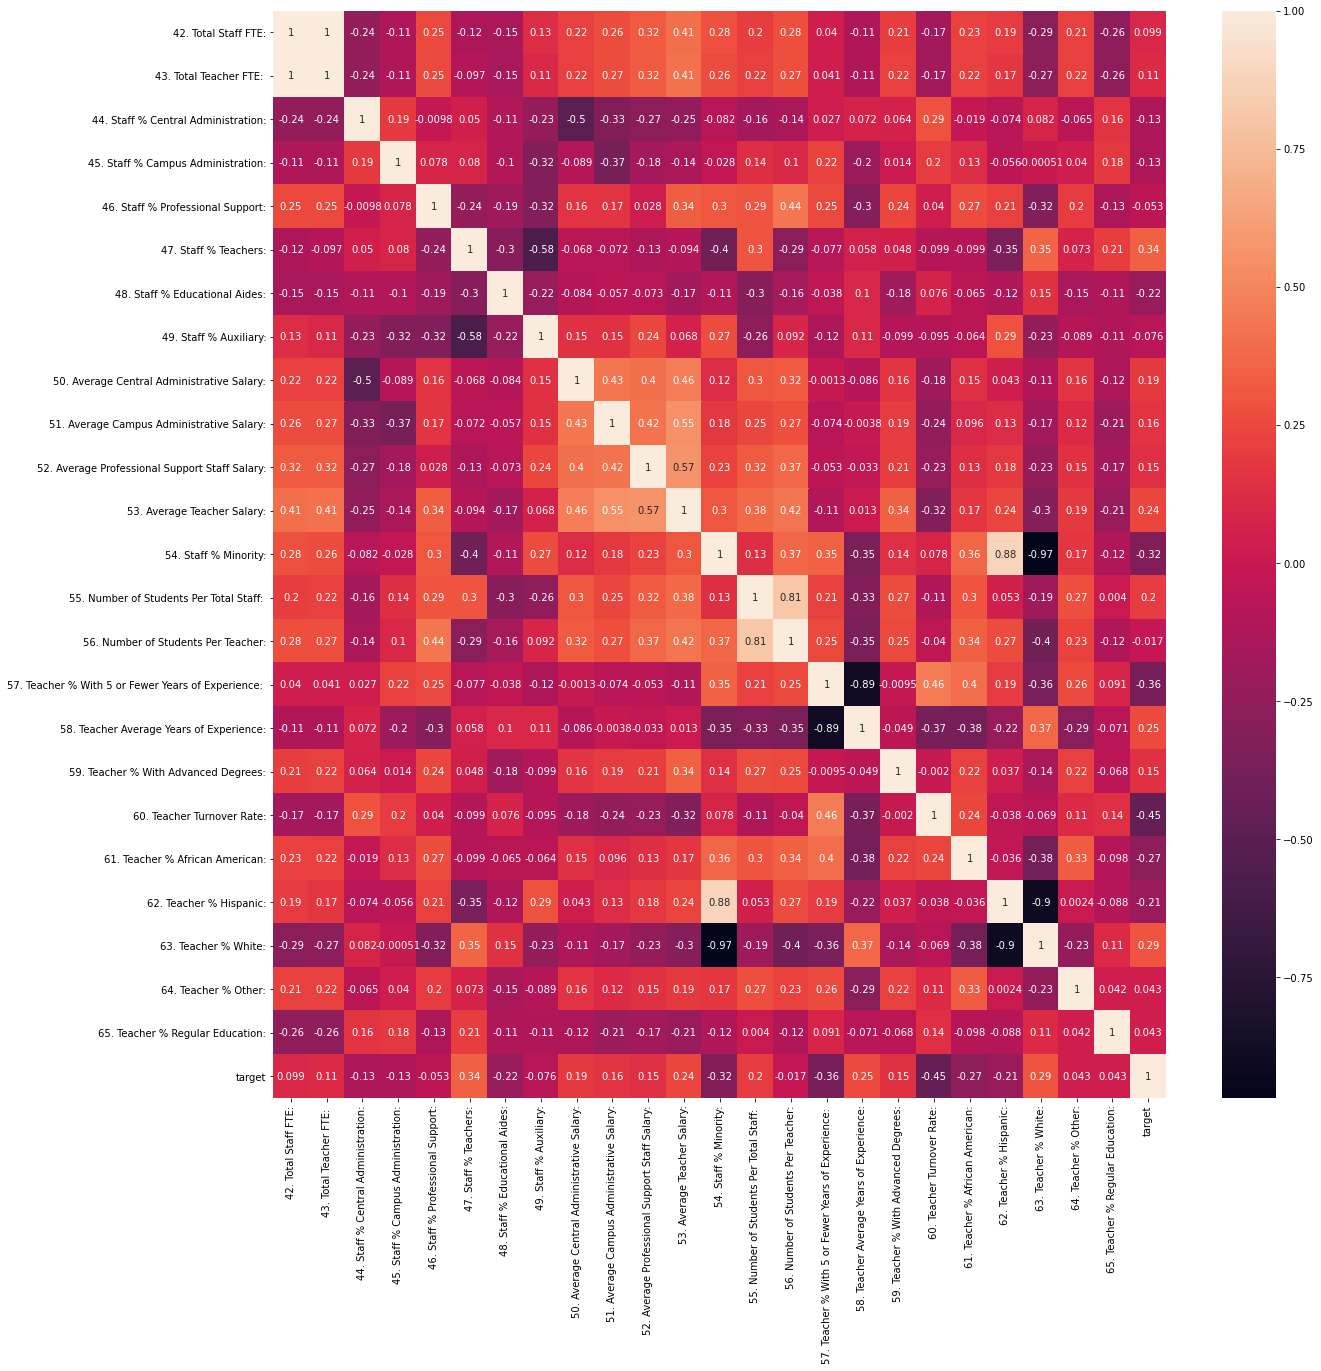

In [35]:
plt.figure(figsize = (20, 20))
sns.heatmap(df2.corr(), annot=True)
plt.show()

In [36]:
#Looks like there's a weak correlation between staff % who are teachers as well as average teacher salary and the percent
#of teachers with advanced degrees. Again all this is fairly obvious however. 
#Looks like there is a negative correlation 

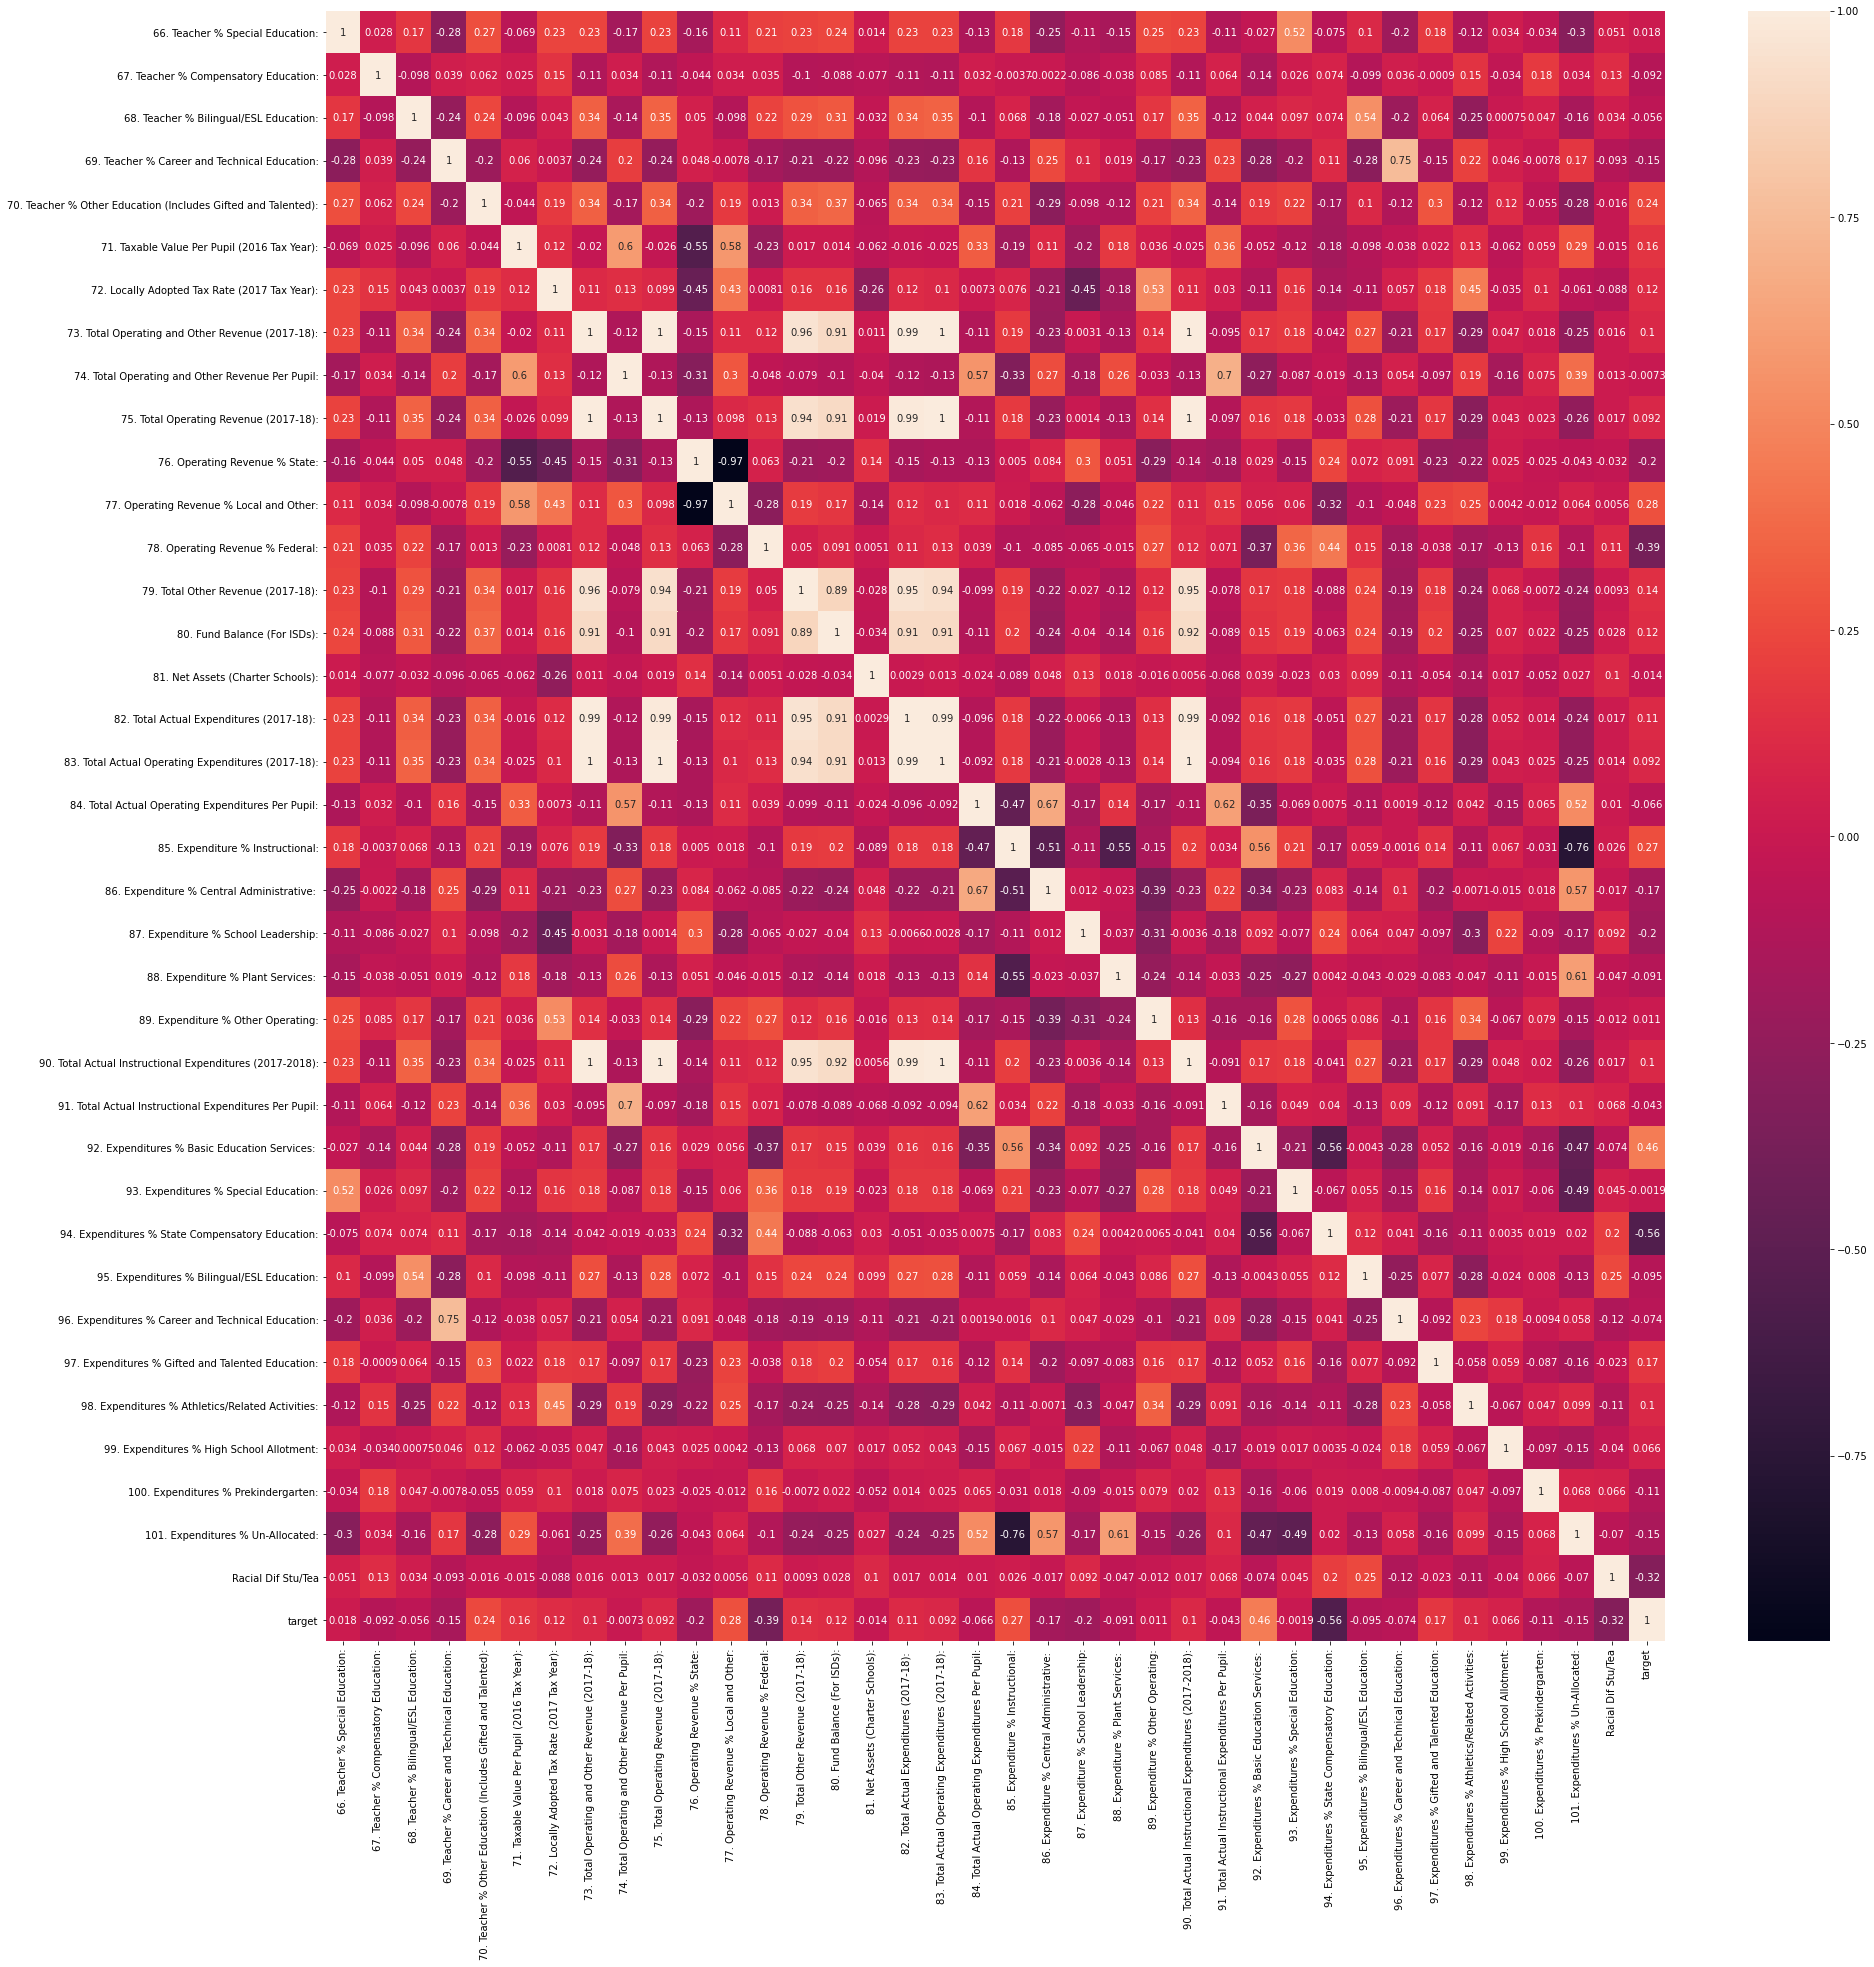

In [37]:
plt.figure(figsize = (30, 30))
sns.heatmap(df3.corr(), annot=True)
plt.show()

In [38]:
#Ah ha! There IS a negative correlation between the ratial diffrences of teachers and staff and staar scores, although it's not 
#Very strong. 
#Since there seemed to be no one (actionable) factor that had a significant correlation to staar scores I'm going to skip
#straight into a multiple linear regression model, though I'm not going to use ALL of my features. I WANT to do a principal
#component analysis but since that is getting covered in a later chapter in more detail and I was very fuzzy on how it worked
#for the ski resort capstone I'm instead going to choose the features with the highest absolute pearson scores, make sure a 
#few of those features are actionable, and create a multiple linear regression model based on what I've got. 

In [39]:
cdf1 = df1.corr()

In [40]:
cdf1 = cdf1.loc[abs(cdf1['target']) > .3]
cdf1.reset_index(inplace=True)
cdf1.iloc[:,0]

0                         5. Students % Hispanic: 
1                             6. Students % White:
2                             8. Students % Asian:
3       11. Students % Economically Disadvantaged:
4    16. Students % Gifted and Talented Education:
5                   17. Attendance Rate (2017-18):
6      18. Annual Dropout Rate Gr. 9-12 (2017-18):
7                                           target
Name: index, dtype: object

In [41]:
features_list = list(cdf1.iloc[:,0])

In [42]:
features_list

['5. Students % Hispanic: ',
 '6. Students % White:',
 '8. Students % Asian:',
 '11. Students % Economically Disadvantaged:',
 '16. Students % Gifted and Talented Education:',
 '17. Attendance Rate (2017-18):',
 '18. Annual Dropout Rate Gr. 9-12 (2017-18):',
 'target']

In [43]:
cdf2 = df2.corr()
cdf2 = cdf2.loc[abs(cdf2['target']) > .3]
cdf2.reset_index(inplace=True)
features_list.append(list(cdf2.iloc[:,0]))
features_list

['5. Students % Hispanic: ',
 '6. Students % White:',
 '8. Students % Asian:',
 '11. Students % Economically Disadvantaged:',
 '16. Students % Gifted and Talented Education:',
 '17. Attendance Rate (2017-18):',
 '18. Annual Dropout Rate Gr. 9-12 (2017-18):',
 'target',
 ['47. Staff % Teachers:',
  '54. Staff % Minority:',
  '57. Teacher % With 5 or Fewer Years of Experience: ',
  '60. Teacher Turnover Rate:',
  'target']]

In [44]:
cdf3 = df3.corr()
cdf3 = cdf3.loc[abs(cdf3['target']) > .3]
cdf3.reset_index(inplace=True)
features_list.append(list(cdf3.iloc[:,0]))
features_list

['5. Students % Hispanic: ',
 '6. Students % White:',
 '8. Students % Asian:',
 '11. Students % Economically Disadvantaged:',
 '16. Students % Gifted and Talented Education:',
 '17. Attendance Rate (2017-18):',
 '18. Annual Dropout Rate Gr. 9-12 (2017-18):',
 'target',
 ['47. Staff % Teachers:',
  '54. Staff % Minority:',
  '57. Teacher % With 5 or Fewer Years of Experience: ',
  '60. Teacher Turnover Rate:',
  'target'],
 ['78. Operating Revenue % Federal:',
  '92. Expenditures % Basic Education Services: ',
  '94. Expenditures % State Compensatory Education:',
  'Racial Dif Stu/Tea',
  'target']]

In [45]:
features_list = ['5. Students % Hispanic: ',
 '6. Students % White:',
 '8. Students % Asian:',
 '11. Students % Economically Disadvantaged:',
 '16. Students % Gifted and Talented Education:',
 '17. Attendance Rate (2017-18):',
 '18. Annual Dropout Rate Gr. 9-12 (2017-18):','47. Staff % Teachers:',
  '54. Staff % Minority:',
  '57. Teacher % With 5 or Fewer Years of Experience: ',
  '60. Teacher Turnover Rate:','78. Operating Revenue % Federal:',
  '92. Expenditures % Basic Education Services: ',
  '94. Expenditures % State Compensatory Education:',
  'Racial Dif Stu/Tea']

In [49]:
dfcut = df[['DISTNAME','5. Students % Hispanic: ',
 '6. Students % White:',
 '8. Students % Asian:',
 '11. Students % Economically Disadvantaged:',
 '16. Students % Gifted and Talented Education:',
 '17. Attendance Rate (2017-18):',
 '18. Annual Dropout Rate Gr. 9-12 (2017-18):','47. Staff % Teachers:',
  '54. Staff % Minority:',
  '57. Teacher % With 5 or Fewer Years of Experience: ',
  '60. Teacher Turnover Rate:','78. Operating Revenue % Federal:',
  '92. Expenditures % Basic Education Services: ',
  '94. Expenditures % State Compensatory Education:',
  'Racial Dif Stu/Tea']]
dfcut['target'] = target
dfcut.set_index('DISTNAME', inplace = True)
dfcut.head()

<ipython-input-49-e12f6d31c9e3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfcut['target'] = target


,5. Students % Hispanic:,6. Students % White:,8. Students % Asian:,11. Students % Economically Disadvantaged:,16. Students % Gifted and Talented Education:,17. Attendance Rate (2017-18):,18. Annual Dropout Rate Gr. 9-12 (2017-18):,47. Staff % Teachers:,54. Staff % Minority:,57. Teacher % With 5 or Fewer Years of Experience:,60. Teacher Turnover Rate:,78. Operating Revenue % Federal:,92. Expenditures % Basic Education Services:,94. Expenditures % State Compensatory Education:,Racial Dif Stu/Tea,target
DISTNAME,,,,,,,,,,,,,,,,
CAYUGA ISD,6.7,84.8,0.5,42.6,8.5,96.5,0.0,51.0,14.1,11.8,7.8,19.3,32.0,3.1,3.63125,61.0
ELKHART ISD,11.3,78.1,0.3,58.1,3.6,96.4,0.0,57.2,10.5,15.1,11.7,6.9,46.2,6.6,7.40625,56.0
FRANKSTON ISD,8.2,78.2,1.0,53.7,8.8,95.4,0.4,49.7,13.3,32.5,30.5,7.0,40.1,7.6,2.98750,53.0
NECHES ISD,13.9,73.2,0.0,47.8,6.0,95.9,0.9,52.4,12.5,26.9,14.4,8.4,36.7,10.2,10.83750,52.0
PALESTINE ISD,41.2,27.5,0.9,74.9,2.9,95.3,0.0,51.7,28.5,34.3,26.1,18.3,46.6,8.1,23.65000,42.0


In [ ]:
#Ok the most significant features have been selected. In this case I believe my actionable features are: Attendance rate(Although
# this is a primary goal for every school district), staff % teachers (which would demonstrate that too much support staff like
# non classroom subject matter specialists, interventionalists, ect are not as effective as hiring more teachers), staff % 
# minority (which is really exciting because it may demonstrate that having diverse staff is helpful as opposed to a diverse 
#student population being harmful), teacher turnover rate (Keep your teachers, raise your scores though I know I'm implying
#causation here), and racial differences between students and staff (highering teachers who look like your students may be
#helpful.) 

#The other features are useful for predictive purposes even if they aren't actionable. 


In [50]:
dfcut.to_csv('snapshot_sig_features.csv')